# ModelChain example

This example shows you the basic usage of the windpowerlib by using the ``ModelChain`` class.
There are mainly three steps. First you have to import your weather data, then you need to specify your wind turbine, and in the last step call the windpowerlib functions to calculate the feed-in time series.

Before you start you have to import the packages needed for these steps.

### Import necessary packages and modules

In [2]:
__copyright__ = "Copyright oemof developer group"
__license__ = "GPLv3"

import os
import pandas as pd

from windpowerlib import ModelChain
from windpowerlib import WindTurbine
from windpowerlib import wind_turbine as wt

You can use the logging package to get logging messages from the windpowerlib. Change the logging level if you want more or less messages.

In [3]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

### Import weather data

In order to use the windpowerlib you need to at least provide wind speed data for the time frame you want to analyze.
The function below imports example weather data from the weather.csv file provided along with the windpowerlib. The data includes wind speed at two different heights in m/s, air temperature in two different heights in K, surface roughness length in m and air pressure in Pa.

To find out which weather data in which units need to be provided to use the ModelChain or other functions of the windpowerlib see the individual function documentation.

In [4]:
def get_weather_data(filename='weather.csv', **kwargs):
    r"""
    Imports weather data from a file.

    The data include wind speed at two different heights in m/s, air
    temperature in two different heights in K, surface roughness length in m
    and air pressure in Pa. The file is located in the example folder of the
    windpowerlib. The height in m for which the data applies is specified in
    the second row.

    Parameters
    ----------
    filename : string
        Filename of the weather data file. Default: 'weather.csv'.

    Other Parameters
    ----------------
    datapath : string, optional
        Path where the weather data file is stored.
        Default: 'windpowerlib/example'.

    Returns
    -------
    weather_df : pandas.DataFrame
        DataFrame with time series for wind speed `wind_speed` in m/s,
        temperature `temperature` in K, roughness length `roughness_length`
        in m, and pressure `pressure` in Pa.
        The columns of the DataFrame are a MultiIndex where the first level
        contains the variable name (e.g. wind_speed) and the second level
        contains the height at which it applies (e.g. 10, if it was
        measured at a height of 10 m).

    """

    if 'datapath' not in kwargs:
        kwargs['datapath'] = os.path.join(os.path.split(
            os.path.dirname(__file__))[0], 'example')
    file = os.path.join(kwargs['datapath'], filename)
    # read csv file 
    weather_df = pd.read_csv(
        file, index_col=0, header=[0, 1],
        date_parser=lambda idx: pd.to_datetime(idx, utc=True))
    # change type of index to datetime and set time zone
    weather_df.index = pd.to_datetime(weather_df.index).tz_convert(
        'Europe/Berlin')
    # change type of height from str to int by resetting columns
    weather_df.columns = [weather_df.axes[1].levels[0][
                              weather_df.axes[1].codes[0]],
                          weather_df.axes[1].levels[1][
                              weather_df.axes[1].codes[1]].astype(int)]
    return weather_df


# Read weather data from csv
weather = get_weather_data(filename='weather.csv', datapath='')
print(weather[['wind_speed', 'temperature', 'pressure']][0:3])

variable_name             wind_speed          temperature         pressure
height                            10       80          2       10       0 
2010-01-01 00:00:00+01:00    5.32697  7.80697      267.60  267.57  98405.7
2010-01-01 01:00:00+01:00    5.46199  7.86199      267.60  267.55  98382.7
2010-01-01 02:00:00+01:00    5.67899  8.59899      267.61  267.54  98362.9


### Initialize wind turbine

To initialize a specific turbine you need a dictionary that contains the basic parameters. A turbine is defined by its nominal power, hub height, rotor diameter, and power or power coefficient curve.

There are three ways to initialize a WindTurbine object in the windpowerlib. You can either specify your own turbine, as done below for 'my_turbine', or fetch power and/or power coefficient curve data from data files provided by the windpowerlib, as done for the 'enercon_e126', or provide your turbine data in csv files as done for the 'dummy_turbine' with an example file.

You can execute the following to get a table of all wind turbines for which power and/or power coefficient curves are provided.

In [5]:
# get power curves
# get names of wind turbines for which power curves and/or are provided
# set print_out=True to see the list of all available wind turbines
df = wt.get_turbine_types(print_out=False)

# find all Enercons
print(df[df["manufacturer"].str.contains("Enercon")])

   manufacturer turbine_type  has_power_curve  has_cp_curve
1       Enercon   E-101/3050             True          True
2       Enercon   E-101/3500             True          True
3       Enercon   E-115/3000             True          True
4       Enercon   E-115/3200             True          True
5       Enercon   E-126/4200             True          True
6       Enercon   E-126/7500             True         False
7       Enercon   E-141/4200             True          True
8       Enercon     E-48/800             True          True
9       Enercon     E-53/800             True          True
10      Enercon    E-70/2000             True          True
11      Enercon    E-70/2300             True          True
12      Enercon    E-82/2000             True          True
13      Enercon    E-82/2300             True          True
14      Enercon    E-82/2350             True          True
15      Enercon    E-82/3000             True          True
16      Enercon    E-92/2350            

In [6]:
# find all Enercon 101 turbines
print(df[df["turbine_type"].str.contains("E-101")])

  manufacturer turbine_type  has_power_curve  has_cp_curve
1      Enercon   E-101/3050             True          True
2      Enercon   E-101/3500             True          True


In [7]:
# specification of own wind turbine (Note: power coefficient values and
# nominal power have to be in Watt)
my_turbine = {
    'name': 'myTurbine',
    'nominal_power': 3e6,  # in W
    'hub_height': 105,  # in m
    'rotor_diameter': 90,  # in m
    'power_curve': pd.DataFrame(
            data={'value': [p * 1000 for p in [
                      0.0, 26.0, 180.0, 1500.0, 3000.0, 3000.0]],  # in W
                  'wind_speed': [0.0, 3.0, 5.0, 10.0, 15.0, 25.0]})  # in m/s
    }  
# initialisze WindTurbine object
my_turbine = WindTurbine(**my_turbine)

In [8]:
# specification of wind turbine where power curve is provided
# if you want to use the power coefficient curve change the value of
# 'fetch_curve' to 'power_coefficient_curve'
enercon_e126 = {
        'name': 'E-126/4200',  # turbine type as in register #
        'hub_height': 135,  # in m
        'rotor_diameter': 127,  # in m
        'fetch_curve': 'power_curve',  # fetch power curve #
        'data_source': 'oedb'  # data source oedb or name of csv file
    }
# initialize WindTurbine object
e126 = WindTurbine(**enercon_e126)

In [9]:
# specification of wind turbine where power coefficient curve is provided
# by a csv file
source = 'data/example_power_coefficient_curves.csv'
dummy_turbine = {
    'name': 'DUMMY 1',  # turbine type as in file #
    'hub_height': 100,  # in m
    'rotor_diameter': 70,  # in m
    'fetch_curve': 'power_coefficient_curve',  # fetch cp curve #
    'data_source': source  # data source
}
# initialize WindTurbine object
dummy_turbine = WindTurbine(**dummy_turbine)

### Use the ModelChain to calculate turbine power output

The ModelChain is a class that provides all necessary steps to calculate the power output of a wind turbine. If you use the 'run_model' method first the wind speed and density (if necessary) at hub height are calculated and then used to calculate the power output. You can either use the default methods for the calculation steps, as done for 'my_turbine', or choose different methods, as done for the 'e126'. Of course, you can also use the default methods while only changing one or two of them, as done for 'dummy_turbine'.

In [10]:
# power output calculation for my_turbine
# initialize ModelChain with default parameters and use run_model
# method to calculate power output
mc_my_turbine = ModelChain(my_turbine).run_model(weather)
# write power output time series to WindTurbine object
my_turbine.power_output = mc_my_turbine.power_output

DEBUG:root:Calculating wind speed using logarithmic wind profile.
DEBUG:root:Calculating power output using power curve.


In [11]:
# power output calculation for e126
# own specifications for ModelChain setup
modelchain_data = {
    'wind_speed_model': 'logarithmic',      # 'logarithmic' (default),
                                            # 'hellman' or
                                            # 'interpolation_extrapolation'
    'density_model': 'ideal_gas',           # 'barometric' (default), 'ideal_gas'
                                            #  or 'interpolation_extrapolation'
    'temperature_model': 'linear_gradient', # 'linear_gradient' (def.) or
                                            # 'interpolation_extrapolation'
    'power_output_model': 'power_curve',    # 'power_curve' (default) or
                                            # 'power_coefficient_curve'
    'density_correction': True,             # False (default) or True
    'obstacle_height': 0,                   # default: 0
    'hellman_exp': None}                    # None (default) or None

# initialize ModelChain with own specifications and use run_model method to
# calculate power output
mc_e126 = ModelChain(e126, **modelchain_data).run_model(
    weather)
# write power output time series to WindTurbine object
e126.power_output = mc_e126.power_output

DEBUG:root:Calculating wind speed using logarithmic wind profile.
DEBUG:root:Calculating temperature using temperature gradient.
DEBUG:root:Calculating density using ideal gas equation.
DEBUG:root:Calculating power output using power curve.


In [12]:
# power output calculation for example_turbine
# own specification for 'power_output_model'
mc_example_turbine = ModelChain(
    dummy_turbine,
    power_output_model='power_coefficient_curve').run_model(weather)
dummy_turbine.power_output = mc_example_turbine.power_output

DEBUG:root:Calculating wind speed using logarithmic wind profile.
DEBUG:root:Calculating temperature using temperature gradient.
DEBUG:root:Calculating density using barometric height equation.
DEBUG:root:Calculating power output using power coefficient curve.


### Plot results

If you have matplotlib installed you can visualize the calculated power output and used power (coefficient) curves.

In [13]:
# try to import matplotlib
try:
    from matplotlib import pyplot as plt
    # matplotlib inline needed in notebook to plot inline
    %matplotlib inline 
except ImportError:
    plt = None

DEBUG:matplotlib:CACHEDIR=C:\Users\gbalestrieri\.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from C:\Users\gbalestrieri\.matplotlib\fontList.json
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('C:\\Users\\gbalestrieri\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000


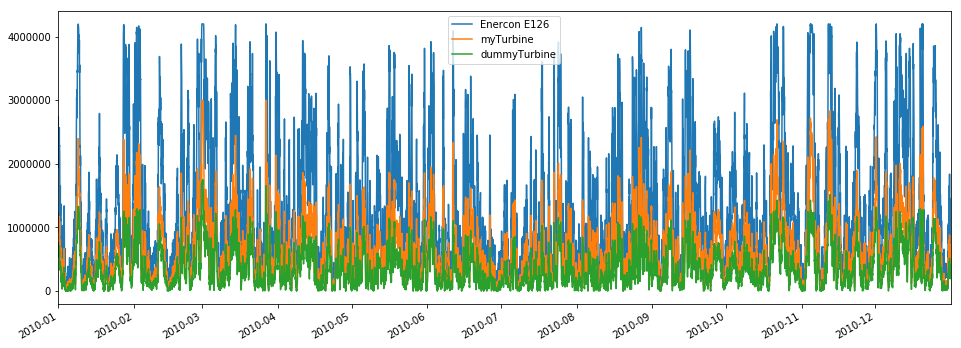

In [14]:
# plot turbine power output
if plt:
    fig, ax = plt.subplots(figsize=(16,6))
    e126.power_output.plot(legend=True, label='Enercon E126', ax=ax)
    my_turbine.power_output.plot(legend=True, label='myTurbine', ax=ax)
    dummy_turbine.power_output.plot(legend=True, label='dummyTurbine', ax=ax)

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('C:\\Users\\gbalestrieri\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000


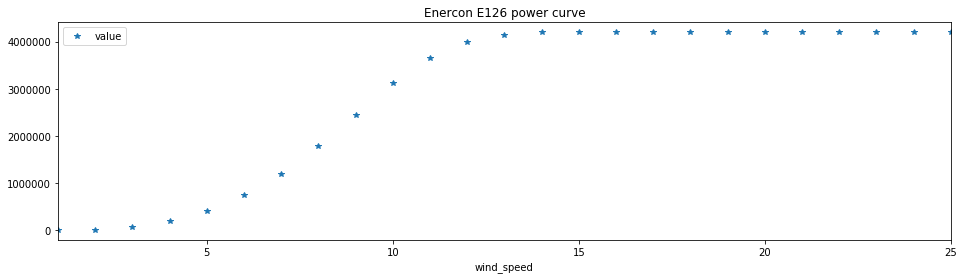

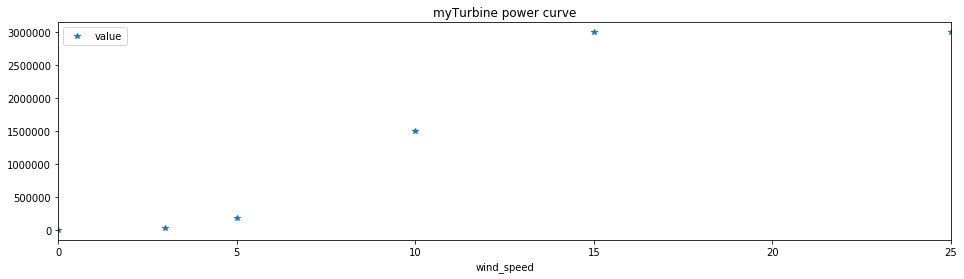

In [15]:
# plot power (coefficient) curves
if plt:
    if e126.power_coefficient_curve is not None:
        e126.power_coefficient_curve.plot(
            x='wind_speed', y='value', style='*',
            title='Enercon E126 power coefficient curve', 
            figsize=(16,4))
    if e126.power_curve is not None:
        e126.power_curve.plot(x='wind_speed', y='value', style='*',
                              title='Enercon E126 power curve', 
                              figsize=(16,4))
    if my_turbine.power_coefficient_curve is not None:
        my_turbine.power_coefficient_curve.plot(
            x='wind_speed', y='value', style='*',
            title='myTurbine power coefficient curve', 
            figsize=(16,4))
    if my_turbine.power_curve is not None:
        my_turbine.power_curve.plot(x='wind_speed', y='value', style='*',
                                    title='myTurbine power curve', 
                                    figsize=(16,4))